## Importing libraries

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
warnings.filterwarnings('ignore')

## Loading data

In [3]:
df = pd.read_csv('/content/Dataset Heart Disease.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,age,sex,chest pain type,resting bps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289.0,0,0,172,0,0.0,1,0
1,49,0,3,160,180.0,0,0,156,0,1.0,2,1
2,37,1,2,130,283.0,0,1,98,0,0.0,1,0
3,48,0,4,138,214.0,0,0,108,1,1.5,2,1
4,54,1,3,150,195.0,0,0,122,0,0.0,1,0


In [4]:
df.shape

(1048, 12)

## Checking for missing values

In [5]:
df.isnull().sum()

,0
age,0
sex,0
chest pain type,0
resting bps,0
cholesterol,0
fasting blood sugar,0
resting ecg,0
max heart rate,0
exercise angina,0
oldpeak,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1048 non-null   int64  
 1   sex                  1048 non-null   int64  
 2   chest pain type      1048 non-null   int64  
 3   resting bps          1048 non-null   int64  
 4   cholesterol          1048 non-null   float64
 5   fasting blood sugar  1048 non-null   int64  
 6   resting ecg          1048 non-null   int64  
 7   max heart rate       1048 non-null   int64  
 8   exercise angina      1048 non-null   int64  
 9   oldpeak              1048 non-null   float64
 10  ST slope             1048 non-null   int64  
 11  target               1048 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 98.4 KB


In [7]:
df.describe()

,age,sex,chest pain type,resting bps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,53.325382,0.734733,2.817748,132.613550,245.172710,0.162214,0.606870,142.918893,0.368321,0.942366,1.532443,0.496183
std,9.397822,0.441686,1.118649,17.367605,57.101359,0.368823,0.763313,24.427115,0.482579,1.100429,0.611023,0.500224
min,28.000000,0.000000,1.000000,92.000000,85.000000,0.000000,0.000000,69.000000,0.000000,-0.100000,0.000000,0.000000
25%,46.000000,0.000000,2.000000,120.000000,208.000000,0.000000,0.000000,125.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,3.000000,130.000000,239.000000,0.000000,0.000000,144.000000,0.000000,0.600000,2.000000,0.000000
75%,60.000000,1.000000,4.000000,140.000000,275.000000,0.000000,1.000000,162.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


## Finding correlation

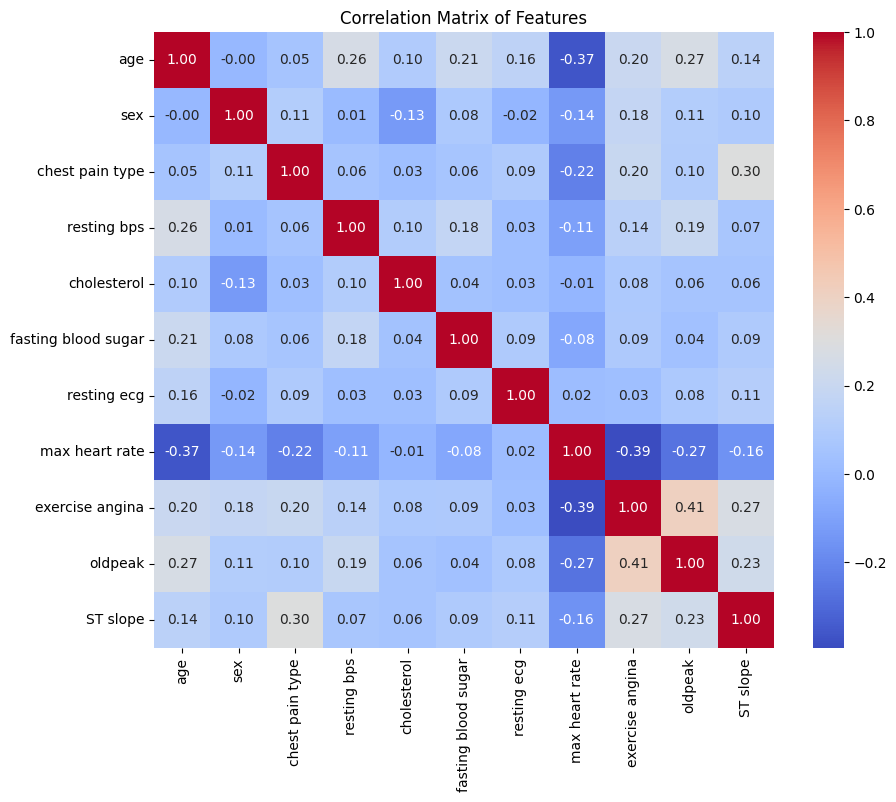

In [8]:
correlation_matrix = df.drop('target', axis=1).corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [9]:
cols = list(df.columns)
num_cols = len(cols)

# Calculate rows and columns for subplots
num_rows = (num_cols + 2) // 4  # Adjust 3 for desired columns per row
num_cols = min(num_cols, 4)      # Ensure no more than 3 columns

# Create subplots figure
fig = sp.make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cols)

# Add each box plot to subplots
for i, col in enumerate(cols):
    row = i // num_cols + 1
    col_num = i % num_cols + 1

    trace = go.Box(y=df[col], name=col, boxpoints='all')
    fig.add_trace(trace, row=row, col=col_num)

# Update layout for better visualization
fig.update_layout(height=400 * num_rows, width=800, title_text="Range of Values for Features")
fig.show()

## Outlier Detection

In [10]:
# Separate dataset features for EDA
# patient_features =

def detect_outliers(dataset_features):
    """
    Detect outliers in the dataset using the Interquartile Range (IQR) method.

    Args:
        dataset_features (pd.DataFrame): Input DataFrame containing numerical features to analyze

    Returns:
        pd.DataFrame: DataFrame containing for each feature:
            - Lower Bound: Q1 - 1.5*IQR threshold for outliers
            - Upper Bound: Q3 + 1.5*IQR threshold for outliers
            - Outliers Count: Number of values outside the bounds
    Notes:
        - Uses the standard 1.5*IQR rule: points below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are considered outliers
    """
    outliers = pd.DataFrame(index=dataset_features.columns)
    # Calculate quantiles
    Q1 = dataset_features.quantile(0.25)
    Q3 = dataset_features.quantile(0.75)
    # Calculate IQR range
    IQR = Q3 - Q1
    # Define upper and lower bounds
    outliers['Lower Bound'] = Q1 - 1.5*IQR
    outliers['Upper Bound'] = Q3 + 1.5*IQR
    #
    outliers['Outliers Count'] = [
        ((dataset_features[col] < outliers.loc[col, 'Lower Bound']) |
         (dataset_features[col] > outliers.loc[col, 'Upper Bound'])).sum()
        for col in dataset_features.columns
    ]
    return outliers

# Print the result of detect_outliers
print("\nOutlier Analysis:")
print(detect_outliers(df.drop('target', axis=1)), '\n')


Outlier Analysis:
                     Lower Bound  Upper Bound  Outliers Count
age                         25.0         81.0               0
sex                         -1.5          2.5               0
chest pain type             -1.0          7.0               0
resting bps                 90.0        170.0              29
cholesterol                107.5        375.5              28
fasting blood sugar          0.0          0.0             170
resting ecg                 -1.5          2.5               0
max heart rate              69.5        217.5               1
exercise angina             -1.5          2.5               0
oldpeak                     -2.4          4.0              11
ST slope                    -0.5          3.5               0 



## Removing Outliers

In [11]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Apply the function to each numerical column
for column in df.select_dtypes(include=np.number).columns:
    df = remove_outliers_iqr(df, column)

df.describe()

,age,sex,chest pain type,resting bps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.0,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,52.296837,0.726277,2.776156,129.902676,239.607056,0.0,0.571776,144.171533,0.338200,0.834550,1.500000,0.467153
std,9.560091,0.446140,1.106295,15.234433,46.937568,0.0,0.751179,24.192811,0.473385,0.972846,0.577174,0.499224
min,28.000000,0.000000,1.000000,92.000000,113.000000,0.0,0.000000,71.000000,0.000000,-0.100000,0.000000,0.000000
25%,45.000000,0.000000,2.000000,120.000000,207.000000,0.0,0.000000,126.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,1.000000,3.000000,130.000000,235.000000,0.0,0.000000,146.000000,0.000000,0.400000,1.000000,0.000000
75%,59.000000,1.000000,4.000000,140.000000,271.000000,0.0,1.000000,163.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,170.000000,369.000000,0.0,2.000000,202.000000,1.000000,3.600000,3.000000,1.000000


## Checking after removal

In [12]:
print("\nOutlier Analysis:")
print(detect_outliers(df.drop('target', axis=1)), '\n')


Outlier Analysis:
                     Lower Bound  Upper Bound  Outliers Count
age                        24.00        80.00               0
sex                        -1.50         2.50               0
chest pain type            -1.00         7.00               0
resting bps                90.00       170.00               0
cholesterol               111.00       367.00               1
fasting blood sugar         0.00         0.00               0
resting ecg                -1.50         2.50               0
max heart rate             70.50       218.50               0
exercise angina            -1.50         2.50               0
oldpeak                    -2.25         3.75               0
ST slope                   -0.50         3.50               0 



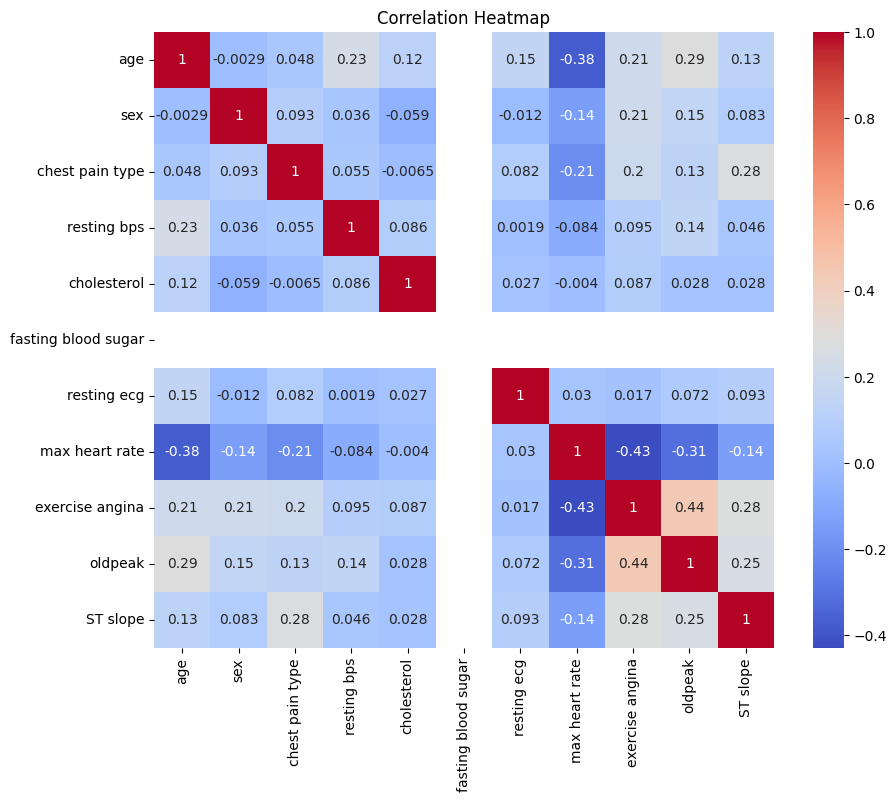

In [13]:
corr = df.drop('target', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Splitting features and target

In [14]:
X = df.drop('target', axis=1)
y = df['target']

## Normalizing data

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Splitting train and test data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [17]:
# Dictionary for storing mean f1_scores, and f1_scores std
feature_performance = {}

# Dictionary for storing all scores instead of just mean and std
all_f1_scores = {}

# Create a list of feature names
features = (X.columns).to_list()

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through each feature to evaluate its individual predictive power
for feature in features:
    # Define the preprocessing and model pipeline steps
    steps = [
        ('scaler', RobustScaler()), # Scale features using RobustScaler to handle outliers
        ('log_reg', LogisticRegression(
            penalty='l1',        # Use L1 (Lasso) regularization for feature selection
            solver='liblinear',  # Solver that supports L1 regularization (required)
            C=1.0,               # Regularization strength (1/lambda)
            max_iter=1000        # Set maximum iterations for convergence
        ))]

    # Create pipeline combining preprocessing and model
    pipeline = Pipeline(steps)

    # Calculate cross-validated F1 scores for each feature
    f1_scores = cross_val_score(pipeline, X_train[:, features.index(feature)].reshape(-1, 1), y_train, cv=kf, scoring='f1_weighted')

    # Store mean and standard deviation of F1 scores
    feature_performance[feature] = {
        'avg_f1_score': f1_scores.mean(),
        'med_f1_score': np.median(f1_scores),
        'f1_std': f1_scores.std()
    }
    # Store all individual F1 scores for later visualization
    all_f1_scores[feature] = f1_scores

# Print Feature Performance Summary
print('Feature Performance Summary:')
for feature, metrics in sorted(feature_performance.items(), key=lambda x: x[1]['avg_f1_score'], reverse=True):
    print(f'\nFeature {feature}:')
    print(f'Avg F1 Score = {metrics["avg_f1_score"]:.4f} (±{metrics["f1_std"]:.4f})')
    print(f'Median F1 Score = {metrics["med_f1_score"]:.4f}')

Feature Performance Summary:

Feature ST slope:
Avg F1 Score = 0.7717 (±0.0370)
Median F1 Score = 0.7658

Feature chest pain type:
Avg F1 Score = 0.6667 (±0.0405)
Median F1 Score = 0.6834

Feature exercise angina:
Avg F1 Score = 0.6349 (±0.0339)
Median F1 Score = 0.6318

Feature oldpeak:
Avg F1 Score = 0.6049 (±0.0571)
Median F1 Score = 0.6032

Feature age:
Avg F1 Score = 0.5444 (±0.0852)
Median F1 Score = 0.5474

Feature max heart rate:
Avg F1 Score = 0.5388 (±0.0861)
Median F1 Score = 0.5573

Feature resting ecg:
Avg F1 Score = 0.4489 (±0.1089)
Median F1 Score = 0.4864

Feature resting bps:
Avg F1 Score = 0.4453 (±0.0823)
Median F1 Score = 0.4694

Feature sex:
Avg F1 Score = 0.3958 (±0.0801)
Median F1 Score = 0.4078

Feature cholesterol:
Avg F1 Score = 0.3958 (±0.0801)
Median F1 Score = 0.4078

Feature fasting blood sugar:
Avg F1 Score = 0.3958 (±0.0801)
Median F1 Score = 0.4078


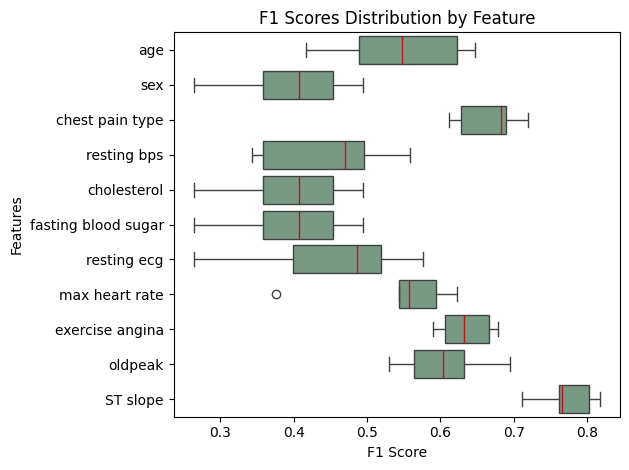

In [19]:
# Create the figure
fig, axes = plt.subplots()

# Create list of data in the correct format
f1_data = pd.DataFrame([all_f1_scores[feature] for feature in features]).T
# Add column names from features(from list of feature names)
f1_data.columns = features

# Create seaborn boxplot
sns.boxplot(data=f1_data, color="#739e82", medianprops={'color': '#c1121f', 'linewidth': 1}, orient='h')

plt.title('F1 Scores Distribution by Feature')
plt.xlabel('F1 Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [20]:
f1_data

,age,sex,chest pain type,resting bps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
0,0.488630,0.358887,0.611500,0.358887,0.358887,0.358887,0.398990,0.557272,0.631847,0.563719,0.802576
1,0.647292,0.494949,0.683391,0.558841,0.494949,0.494949,0.576248,0.593697,0.590725,0.632283,0.761339
2,0.547392,0.407820,0.689639,0.469416,0.407820,0.407820,0.486448,0.543996,0.667096,0.603232,0.817503
3,0.416217,0.263846,0.628568,0.343453,0.263846,0.263846,0.263846,0.375730,0.606133,0.529734,0.711146
4,0.622624,0.453726,0.720362,0.496098,0.453726,0.453726,0.519103,0.623209,0.678699,0.695403,0.765822


In [46]:
# Create pipeline for the final model
final_pipeline = Pipeline([
    ('scaler', RobustScaler()),          # Scale features to handle outliers
    ('log_reg', LogisticRegression(
        penalty='l1',                     # L1 regularization for feature selection
        solver='liblinear',               # Required solver for L1
        C=1.0,                           # Regularization strength
        max_iter=1000                    # Maximum iterations to ensure convergence
    ))
])

# Train the model on full training dataset
final_pipeline.fit(X_train, y_train)

# Evaluate model performance
def evaluate_model(pipeline, X_train, y_train, X_test, y_test):
    """
    Evaluate model performance on both training and test sets.
    Check the model for over/underfitting.

    Args:
        pipeline: Trained model pipeline
        X_train, y_train: Training data
        X_test, y_test: Test data

    Returns:
        train_accuracy, test_accuracy, test_f1, y_pred
    """
    # Calculate training performance
    train_accuracy = pipeline.score(X_train, y_train)
    print('Training Metric')
    print(f'Training Accuracy: {train_accuracy*100:.2f}%')

    # Calculate test performance
    test_accuracy = pipeline.score(X_test, y_test)
    y_pred = pipeline.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print('\nTest Metrics')
    print(f'Test Accuracy: {test_accuracy*100:.2f}%')
    print(f'Test F1 Score: {test_f1*100:.2f}%')

    # Assess model fit
    print('\nModel Fit Analysis')
    if train_accuracy > test_accuracy + 0.05:
        print('Warning: Potential overfitting (>5% difference in accuracies)')
    elif train_accuracy < 0.6 and test_accuracy < 0.6:
        print('Warning: Potential underfitting (accuracies below 60%)')
    else:
        print('Good fit: Model shows balanced performance')

    return train_accuracy, test_accuracy, test_f1, y_pred

# Evaluate the final model
train_accuracy, test_accuracy, test_f1, y_pred = evaluate_model(
   final_pipeline, X_train, y_train, X_test, y_test
)

Training Metric
Training Accuracy: 75.95%

Test Metrics
Test Accuracy: 78.79%
Test F1 Score: 78.81%

Model Fit Analysis
Good fit: Model shows balanced performance


In [47]:
le = LabelEncoder()
y = le.fit_transform(df['target'])
# Create predictions dataframe
predictions = pd.DataFrame() # Initialize predictions as a DataFrame
y_test_encoded = le.transform(y_test)
predictions['actual_state'] = le.inverse_transform(y_test_encoded)    # Add actual values
predictions['predicted_state'] = le.inverse_transform(y_pred)  # Add predicted values


# Show first 10 rows
predictions.head(10)

,actual_state,predicted_state
0,0,0
1,1,0
2,1,1
3,0,0
4,1,1
5,0,0
6,0,0
7,0,0
8,1,1
9,1,0


In [22]:
!pip install flaml

In [23]:
from flaml import AutoML
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

automl = AutoML()

settings = {'time_budget': 120, 'metric': 'accuracy', 'task': 'classification', 'verbose': 1}
automl.fit(X_train, y_train, **settings)

y_pred = automl.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


Accuracy: 0.7878787878787878
              precision    recall  f1-score   support

           0       0.77      0.76      0.77        75
           1       0.80      0.81      0.81        90

    accuracy                           0.79       165
   macro avg       0.79      0.79      0.79       165
weighted avg       0.79      0.79      0.79       165

[[57 18]
 [17 73]]


In [24]:
print(f"Best model:{automl.model.estimator}")

Best model:LGBMClassifier(learning_rate=0.1442707811690549, max_bin=511,
               min_child_samples=4, n_estimators=17, n_jobs=-1, num_leaves=7,
               reg_alpha=0.0009765625, reg_lambda=0.3375228489067647,
               verbose=-1)


In [48]:
import lightgbm as lgb

clf = lgb.LGBMClassifier(learning_rate=0.1442707811690549, max_bin=511,
               min_child_samples=4, n_estimators=17, n_jobs=-1, num_leaves=7,
               reg_alpha=0.0009765625, reg_lambda=0.3375228489067647,
               verbose=-1)
clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.1442707811690549, max_bin=511,
               min_child_samples=4, n_estimators=17, n_jobs=-1, num_leaves=7,
               reg_alpha=0.0009765625, reg_lambda=0.3375228489067647,
               verbose=-1)

In [49]:
y_pred=clf.predict(X_test)

In [50]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7879


In [51]:
y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8250


In [52]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.8250
Test set score: 0.7879


<Axes: >

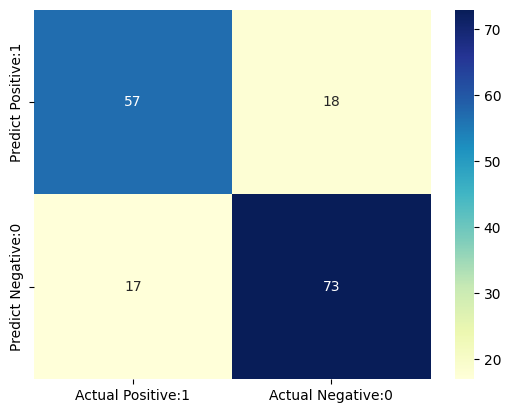

In [53]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [54]:
predictions = pd.DataFrame() # Initialize predictions as a DataFrame
y_test_encoded = le.transform(y_test)
predictions['actual_state'] = le.inverse_transform(y_test_encoded)    # Add actual values
predictions['predicted_state'] = le.inverse_transform(y_pred)  # Add predicted values


# Show first 10 rows
predictions.head(10)

,actual_state,predicted_state
0,0,1
1,1,1
2,1,1
3,0,0
4,1,1
5,0,0
6,0,0
7,0,0
8,1,1
9,1,1


In [31]:
!pip install scikit-learn==1.1.3
from xgboost import XGBClassifier

bst = XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8294060010952675, colsample_bynode=None,
              colsample_bytree=0.9723094537249072, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10691807154662496,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1.5305936157509512,
              monotone_constraints=None, multi_strategy=None, n_estimators=74,
              n_jobs=-1, num_parallel_tree=None, random_state=None)
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8294060010952675, colsample_bynode=None,
              colsample_bytree=0.9723094537249072, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10691807154662496,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1.5305936157509512, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=74,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [55]:
y_pred = bst.predict(X_test)

In [56]:
accuracy=accuracy_score(y_pred, y_test)
print('XGBClassifier Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

XGBClassifier Model accuracy score: 0.7818


In [57]:
y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8250


In [58]:
print('Training set score: {:.4f}'.format(bst.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(bst.score(X_test, y_test)))

Training set score: 0.9970
Test set score: 0.7818


<Axes: >

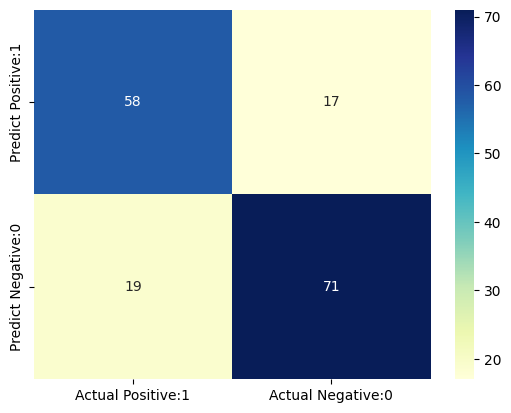

In [59]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [60]:
predictions = pd.DataFrame() # Initialize predictions as a DataFrame
y_test_encoded = le.transform(y_test)
predictions['actual_state'] = le.inverse_transform(y_test_encoded)    # Add actual values
predictions['predicted_state'] = le.inverse_transform(y_pred)  # Add predicted values


# Show first 10 rows
predictions.head(10)

,actual_state,predicted_state
0,0,1
1,1,1
2,1,1
3,0,0
4,1,1
5,0,0
6,0,0
7,0,0
8,1,0
9,1,1
